In [1]:
%pylab inline
import pandas as pd
from dateparser import parse
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
import itertools as it

Populating the interactive namespace from numpy and matplotlib


In [2]:
ex = pd.ExcelFile('WDImetadata.xlsx')
explainer = ex.parse('2010-2019 MetaData').set_index('Code').fillna('')
def explain(c, topic='Long definition'):
    global explainer
    return explainer.loc[c][topic]

In [3]:
def z_score(s):
    return (s-s.mean())/s.std()

In [20]:
df = pd.read_csv('cleaned.csv', parse_dates=['Custom_Time_Code'])
df = df[df['Country Code'] != 'USA']

df_z = pd.concat([z_score(df[col]) for col in tqdm(df.columns) if col not in ['Country Code', 'Custom_Time_Code']], axis=1)
df_z.columns = df.columns[2:]

df_no_outliers = df.where(df_z.abs() < 2).iloc[:,2:]
df_no_outliers = pd.concat([df['Country Code'], df['Custom_Time_Code'], df_no_outliers], axis=1)

df_2010 = df[df['Custom_Time_Code'] > parse('Jan 1st 2009')]
data = df_2010.iloc[:, 2:]

data_z = pd.concat([z_score(data[col]) for col in tqdm(data.columns)], axis=1)
data_z.columns = data.columns

data_no_outliers = data.where(data_z.abs() < 2)
data_no_outliers = data_no_outliers.set_index(df_2010['Country Code'])

100%|██████████| 938/938 [00:01<00:00, 644.43it/s]


In [5]:
corr_no_outliers = data_no_outliers.corr('pearson')

visited = set()
r_values = []
for i,j in tqdm(it.product(data.columns, data.columns)):
    i_prefix = i.split('.')[0]
    j_prefix = j.split('.')[0]
    if (i!=j) and (i_prefix != j_prefix) and ((j,i) not in visited):
        r = corr_no_outliers.loc[i, j]
        r_values.append((r, i, j))
        visited.add((i,j))
        
between_set_corr = pd.DataFrame.from_records(r_values)

between_set_corr.columns = ['r', 'i', 'j']

879844it [00:15, 58243.11it/s] 


In [72]:
'''
Select features from between-set corr
'''
feature_of_interest = 'NY.GDP.PCAP.CD'

isolated_corr = between_set_corr[between_set_corr.i == feature_of_interest][['j','r']]

n_features = 10

curr_n = 0
i = .9
i_delta = .01
while curr_n < n_features:
    i -= i_delta
    curr_n = isolated_corr[isolated_corr.r.abs().between(i, .9)].shape[0]

features = list(isolated_corr[isolated_corr.r.abs().between(i, .9)].j.values)

In [73]:
grouped = df_no_outliers.groupby('Country Code')

drop = set()
for col in tqdm(features):
    counted = grouped[col].count()
    for country in counted.index[counted < 3]:
        drop.add(country)
        
drop.add('USA')

grab = ['Country Code', 'Custom_Time_Code'] + features
grab.append(feature_of_interest)

preserved = df_no_outliers[df_no_outliers['Country Code'].apply(lambda x: x not in drop)][grab]

100%|██████████| 11/11 [00:00<00:00, 569.36it/s]


In [74]:
def s_chg(s):
    s = s.values
    return s[-1]-s[0]

def df_chg(df):
    new = []
    for c in df.columns:
        new.append(s_chg(df[c]))
    new = pd.Series(new)
    new.index = ['DELTA_' + c for c in df.columns]
    return new

In [75]:
col_to_predict = feature_of_interest

past = preserved[preserved['Custom_Time_Code'] < parse('Jan 1st, 2010')]

present = preserved[preserved['Custom_Time_Code'] > parse('Jan 1st, 2010')]


changes = past.groupby('Country Code').apply(df_chg)

present_changes = present.groupby('Country Code').apply(df_chg)


yr_2000 = preserved[preserved['Custom_Time_Code'].between(parse('Jan 1st, 1995'), parse('Jan 1st, 2010'))].set_index('Country Code')
yr_2000['country'] = yr_2000.index


yr_2010 = preserved[preserved['Custom_Time_Code'] > parse('Jan 1st, 2010')].set_index('Country Code')
yr_2010['country'] = yr_2000.index

X = pd.concat([yr_2000, changes], axis=1).drop(['Custom_Time_Code','country','DELTA_Custom_Time_Code'], axis=1)
X = X.fillna(X.mean())

X_for_extrapolation = pd.concat([yr_2010, present_changes], axis=1).drop(['Custom_Time_Code','country','DELTA_Custom_Time_Code'], axis=1)
X_for_extrapolation = X_for_extrapolation.fillna(X_for_extrapolation.mean())


y = preserved[preserved['Custom_Time_Code'] > parse('Jan 1st, 2010')].set_index('Country Code')[col_to_predict]
y = y.fillna(y.mean())

reg = LinearRegression().fit(X, y)

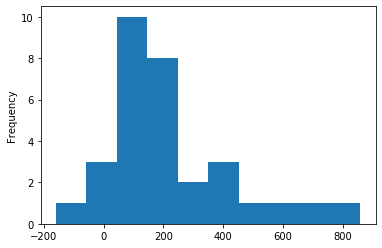

In [76]:
changes["DELTA_"+col_to_predict].plot(kind='hist')

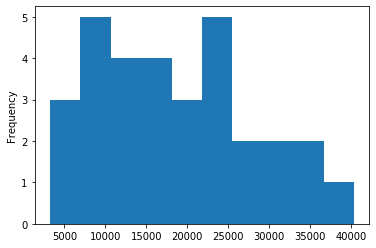

In [77]:
(reg.predict(X_for_extrapolation) - y).plot(kind='hist')